# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [1]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = ''

# To create the same dataset
random.seed(0)

In [2]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = '/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn'

In [3]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['rose', 'tulip', 'sunflower', 'daisy', 'dandelion']


['/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn/flowers/rose',
 '/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn/flowers/tulip',
 '/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn/flowers/sunflower',
 '/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn/flowers/daisy',
 '/home/dntran/Documents/code/lund/EDAN95_applied_ai_lund/lab_3_cnn/flowers/dandelion']

We build the (image, label) pairs

In [4]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('2053476785_c162a3e358.jpg', 'rose'),
 ('6732261031_861a1026fa_n.jpg', 'rose'),
 ('5001850817_abffea40c9_n.jpg', 'rose'),
 ('7471890996_e61b134867_n.jpg', 'rose'),
 ('8063462557_e0a8bd6c64_n.jpg', 'rose'),
 ('7461898018_7e12128f14_n.jpg', 'rose'),
 ('5001855107_71351ce785_n.jpg', 'rose'),
 ('12406418663_af20dc225f_n.jpg', 'rose'),
 ('272481307_1eb47ba3e0_n.jpg', 'rose'),
 ('3621011057_0d03bd171b_n.jpg', 'rose')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [5]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [6]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

Using TensorFlow backend.


Create now the data generators for the training, validation, and test set

In [8]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, shuffle=False)
val_generator = val_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20)

Found 2594 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS` And fit your model

In [9]:

model_name = 'first_train'
model_path = f'./models/{model_name}'
model_save_path = f'./{model_name}.h5'
model_weight_path = f'./{model_name}_weight.h5'
retrain = True
if not os.path.exists(model_save_path) or retrain:

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))

    model.summary()

    model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.RMSprop(lr = 1e-4),
                metrics = ['acc'])
    
    model.save(model_save_path)
    history = model.fit_generator(train_generator, steps_per_epoch=129, epochs=30, validation_data= val_generator, validation_steps=43)
    model.save_weights(model_weight_path)

else:
    model = models.load_model(model_save_path)
    print('Loaded model %s' %model_name)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

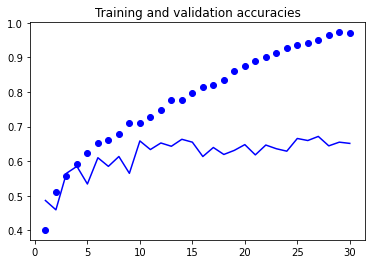

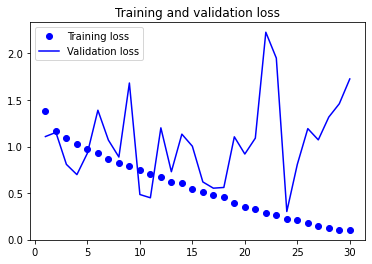

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracies')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### Predicting the test set

Apply now your network to the test set

In [11]:
predictions_on_all_classes = model.predict_generator(test_generator)
predictions = np.argmax(predictions_on_all_classes, axis=1)
predictions

array([4, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 2,
       0, 3, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 4, 1, 0, 0, 0, 0, 4, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 1, 4, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 1, 3, 0, 2, 0, 3, 0, 2, 4, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 3, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 3, 0,
       0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 4, 2, 3, 0, 0, 1, 0, 1, 0, 0, 1,
       2, 1, 1, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1,
       3, 1, 0, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

Report the accuracy as well as the classification report. Use sklearn functions

In [12]:
print('Accuracy: ', accuracy_score(test_generator.classes, predictions))

Accuracy:  0.6339491916859122


Print the confusion matrix

Classification report for classifier CNN: 
               precision    recall  f1-score   support

           0       0.64      0.56      0.59       176
           1       0.57      0.83      0.68       188
           2       0.55      0.56      0.56       154
           3       0.76      0.71      0.74       150
           4       0.72      0.51      0.60       198

    accuracy                           0.63       866
   macro avg       0.65      0.63      0.63       866
weighted avg       0.65      0.63      0.63       866




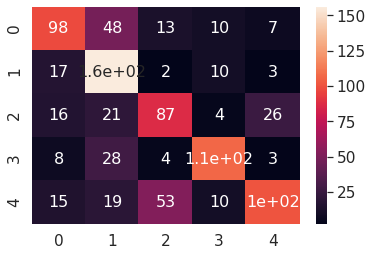

In [13]:
from print_classification_report import print_classification_report
print_classification_report("CNN", test_generator.classes, predictions)

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [14]:
# Write your code here
result = model.evaluate_generator(test_generator)
dict(zip(model.metrics_names, result))

{'loss': 2.60695481300354, 'acc': 0.6339492201805115}

In [15]:
test_loss_1, test_acc_1 = result

Try to improve your model by modifying some parameters and evaluate your network again.

In [16]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(64, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(128, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(128, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(5, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics = ['acc'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [17]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.3, horizontal_flip=True, shear_range=0.2, rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150),batch_size=20)

Found 2594 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [18]:
history = model_2.fit_generator(train_generator, steps_per_epoch=129, epochs=30, validation_data= val_generator, validation_steps=43)

model_2.save('./model_2.h5')

Epoch 1/30
129/129 [==============================] - 18s 142ms/step - loss: 1.3187 - acc: 0.4091 - val_loss: 1.2172 - val_acc: 0.4814
Epoch 2/30
129/129 [==============================] - 24s 186ms/step - loss: 1.1516 - acc: 0.5256 - val_loss: 0.9097 - val_acc: 0.5350
Epoch 3/30
129/129 [==============================] - 25s 194ms/step - loss: 1.0681 - acc: 0.5812 - val_loss: 0.8401 - val_acc: 0.6406
Epoch 4/30
129/129 [==============================] - 27s 207ms/step - loss: 0.9644 - acc: 0.6356 - val_loss: 0.8445 - val_acc: 0.6394
Epoch 5/30
129/129 [==============================] - 32s 246ms/step - loss: 0.9373 - acc: 0.6437 - val_loss: 1.1038 - val_acc: 0.6524
Epoch 6/30
129/129 [==============================] - 30s 230ms/step - loss: 0.8941 - acc: 0.6566 - val_loss: 0.7581 - val_acc: 0.6512
Epoch 7/30
129/129 [==============================] - 30s 235ms/step - loss: 0.8638 - acc: 0.6709 - val_loss: 0.9866 - val_acc: 0.6085
Epoch 8/30
129/129 [==============================] - 3

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


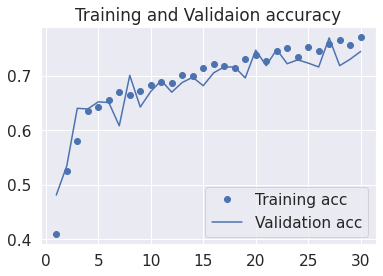

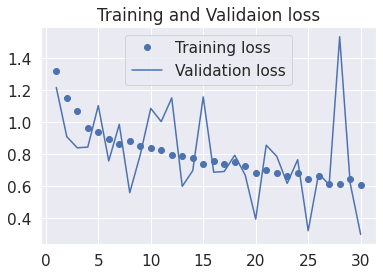

In [19]:
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()


### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

Classification report for classifier Auggmented CNN: 
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       176
           1       0.84      0.75      0.79       188
           2       0.59      0.59      0.59       154
           3       0.66      0.95      0.78       150
           4       0.71      0.65      0.68       198

    accuracy                           0.72       866
   macro avg       0.73      0.73      0.72       866
weighted avg       0.74      0.72      0.72       866




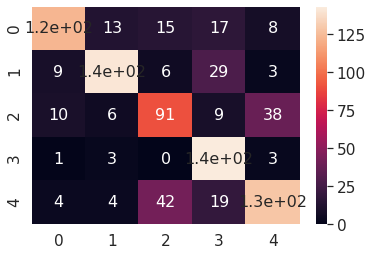

{'loss': 1.3421846628189087, 'acc': 0.7240184545516968}

In [20]:
from print_classification_report import print_classification_report

predictions_on_all_classes = model_2.predict_generator(test_generator)
predictions = np.argmax(predictions_on_all_classes, axis=1)
print_classification_report('Auggmented CNN', test_generator.classes, predictions)

result_2 = model_2.evaluate_generator(test_generator)
dict(zip(model.metrics_names, result_2))

## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [21]:
from keras.applications import VGG16, InceptionV3

In [22]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

[0]              
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 7, 7, 192)    147456      average_pooling2d_7[0][0]        
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 7, 7, 192)    576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 7, 7, 192)    576         conv2d_72[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 7, 7, 192)    576         conv2d_77[0][0]                  
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 7, 7, 192)    576         conv2d_78[0][0]           

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [23]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    datagen = ImageDataGenerator(rescale=1./255)
    batch_size = 20
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size, :] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

The features and labels

In [24]:
train_features, train_labels = extract_features(train_dir, 2594)
test_features, test_labels = extract_features(test_dir, 866)
validation_features, validation_labels = extract_features(validation_dir, 863)


Found 2594 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


In [25]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2594, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (863, 3 * 3 * 2048)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (866, 3 * 3 * 2048))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [26]:
model_3 = models.Sequential()
model_3.add(layers.Dense(256, activation='relu', input_dim=3*3*2048))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(5, activation='softmax'))

model_3.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

Fit your network

In [27]:
history = model_3.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

model_3.save('./model_3.h5')

Train on 2594 samples, validate on 863 samples
Epoch 1/30
2594/2594 [==============================] - 2s 866us/step - loss: 1.3319 - acc: 0.5524 - val_loss: 0.7427 - val_acc: 0.7219
Epoch 2/30
2594/2594 [==============================] - 2s 835us/step - loss: 0.7634 - acc: 0.7217 - val_loss: 0.6188 - val_acc: 0.7752
Epoch 3/30
2594/2594 [==============================] - 2s 838us/step - loss: 0.5894 - acc: 0.7845 - val_loss: 0.5969 - val_acc: 0.7787
Epoch 4/30
2594/2594 [==============================] - 2s 839us/step - loss: 0.4825 - acc: 0.8269 - val_loss: 0.5664 - val_acc: 0.7937
Epoch 5/30
2594/2594 [==============================] - 2s 828us/step - loss: 0.3883 - acc: 0.8631 - val_loss: 0.5382 - val_acc: 0.7949
Epoch 6/30
2594/2594 [==============================] - 2s 827us/step - loss: 0.3213 - acc: 0.8870 - val_loss: 0.5526 - val_acc: 0.8111
Epoch 7/30
2594/2594 [==============================] - 2s 827us/step - loss: 0.2905 - acc: 0.9013 - val_loss: 0.5366 - val_acc: 0.8019
E

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

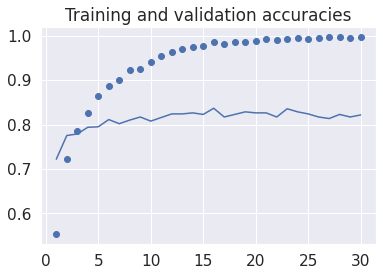

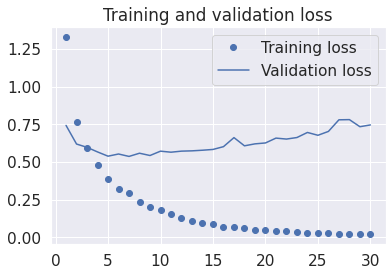

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracies')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [30]:
# Write your code here
predictions_on_all_classes = model_3.predict(test_features)
predictions = np.argmax(predictions_on_all_classes, axis = 1)

Report the accuracy as well as the classification report. Use sklearn functions

Classification report for classifier Pretrained CNN: 
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       176
           1       0.86      0.84      0.85       188
           2       0.71      0.81      0.76       154
           3       0.81      0.86      0.83       150
           4       0.80      0.78      0.79       198

    accuracy                           0.81       866
   macro avg       0.82      0.82      0.81       866
weighted avg       0.82      0.81      0.82       866




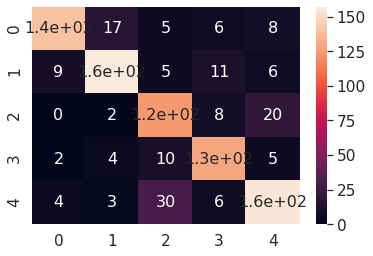

In [31]:
from print_classification_report import print_classification_report

print_classification_report("Pretrained CNN", np.argmax(test_labels, axis = 1), np.argmax(predictions_on_all_classes, axis=1))

Print the confusion matrix

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [32]:
# Write your code here
result_3 = model_3.evaluate(test_features, test_labels)
dict(zip(model.metrics_names, result_3))

866/866 [==============================] - 0s 341us/step


{'loss': 0.8534354210312868, 'acc': 0.8140877485275269}

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [33]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

][0]             
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_16[0][0]       
__________________________________________________________________________________________________
batch_normalization_155 (BatchN (None, 7, 7, 192)    576         conv2d_163[0][0]                 
__________________________________________________________________________________________________
batch_normalization_158 (BatchN (None, 7, 7, 192)    576         conv2d_166[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 7, 7, 192)    576         conv2d_171[0][0]                 
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 7, 7, 192)    576         conv2d_172[0][0]          

Create the generators

In [34]:
# Write your code
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=50, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.3, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, shuffle=False)
val_generator = val_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20)

Found 2594 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


Define the model

In [35]:
from keras import models, layers

model_4 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model_4.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])

In [37]:
model_4.layers[0].trainable = False

Fit the model

In [38]:
history = model_4.fit_generator(train_generator, steps_per_epoch=129, epochs=30, validation_data= val_generator, validation_steps=43)
model_4.save('./model_4.h5')

Epoch 1/30
129/129 [==============================] - 261s 2s/step - loss: 1.7107 - acc: 0.3862 - val_loss: 30269772.0000 - val_acc: 0.2349
Epoch 2/30
129/129 [==============================] - 228s 2s/step - loss: 1.1220 - acc: 0.5684 - val_loss: 71150010368.0000 - val_acc: 0.2361
Epoch 3/30
129/129 [==============================] - 236s 2s/step - loss: 0.9780 - acc: 0.6247 - val_loss: 29557766.0000 - val_acc: 0.2301
Epoch 4/30
129/129 [==============================] - 226s 2s/step - loss: 1.0317 - acc: 0.6041 - val_loss: 924350647631872.0000 - val_acc: 0.2313
Epoch 5/30
129/129 [==============================] - 253s 2s/step - loss: 0.8442 - acc: 0.6857 - val_loss: 201048862234771456.0000 - val_acc: 0.1661
Epoch 6/30
129/129 [==============================] - 124s 961ms/step - loss: 0.7564 - acc: 0.7218 - val_loss: 1489424596598784.0000 - val_acc: 0.1554
Epoch 7/30
129/129 [==============================] - 149s 1s/step - loss: 0.8370 - acc: 0.6946 - val_loss: 1.6132 - val_acc: 0.1

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


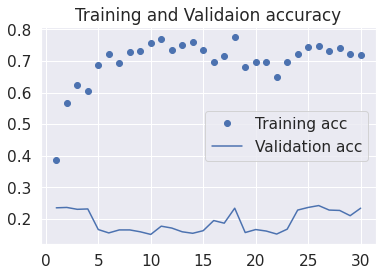

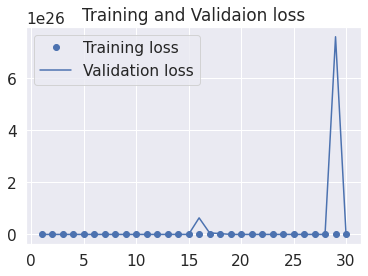

In [39]:
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()


### Predicting the test set

Apply now your network to the test set

In [40]:
predictions_on_all_classes = model_4.predict_generator(test_generator)
predictions = np.argmax(predictions_on_all_classes, axis=1)

Report the accuracy as well as the classification report. Use sklearn functions

Classification report for classifier Pretrained CNN with Data Augmentation: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00       188
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00       150
           4       0.23      1.00      0.37       198

    accuracy                           0.23       866
   macro avg       0.05      0.20      0.07       866
weighted avg       0.05      0.23      0.09       866




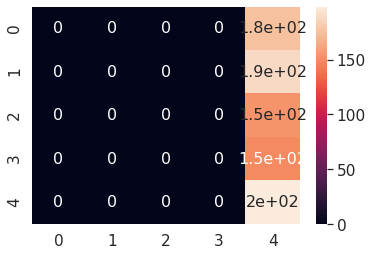

In [41]:
from print_classification_report import print_classification_report

print_classification_report("Pretrained CNN with Data Augmentation", test_generator.classes, predictions)


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [42]:
# Write your code
result_4 = model_4.evaluate_generator(test_generator)
dict(zip(model_4.metrics_names, result_4))


{'loss': 1.4895449876785278, 'acc': 0.22863741219043732}

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.

You will submit this report through Canvas.